In [ ]:
### Calc_channel_area
Prototype of one approach for quantifying eroded areas


In [ ]:
from PIL import Image
import numpy as np
from scipy import ndimage
import xarray as xr
import matplotlib.pyplot as plt
from scipy import interpolate, signal
%matplotlib inline

# read in the multi-map .nc file
fn = 'ncorebx_v4.nc'
dsa = xr.open_dataset(fn)
dsaa = np.squeeze(dsa.to_array())
nmaps,ncross,nalong=np.shape(dsaa)
print('nmaps, ncross, nalong: ',nmaps,ncross,nalong)

# Correct for uniform offsets
offset = np.array([-0.022233, 0.002373, 0.004543, 0.015317])
for i in range(0,nmaps):
    dsaa[i,:,:] = dsaa[i,:,:] + offset[i] 

# NaNs below -1m
dsaa = dsaa.where(dsaa>=-1.0)

# Calculate difference maps
diffmap = np.squeeze(np.diff(dsaa,axis=0))

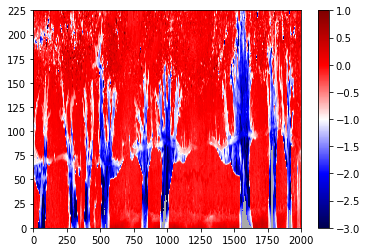

In [11]:
# Look at a portion of the diff map
dcmap=plt.cm.seismic
dcmap.set_bad(color='darkgray')
plt.pcolormesh(diffmap[0,775:1000,18000:20000],cmap=dcmap,vmin=-3,vmax=1)
plt.colorbar()

C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less_equal
  This is separate from the ipykernel package so we can avoid doing imports until


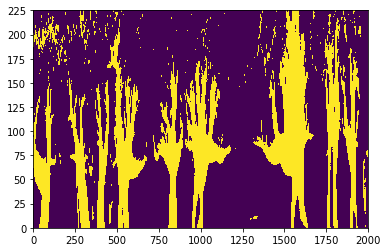

In [14]:
# Threshold to produce a binary map - results will be sensitive to threshold value
dmap = diffmap[0,775:1000,18000:20000]
img = dmap<=-0.5
plt.pcolormesh(img)

(225, 2000)
Number of objects is 40


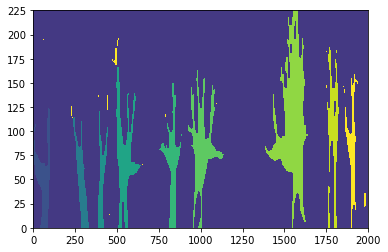

In [98]:
# Label contiguous areas in binary map

# results will be sensitive to these values
blur_radius = 1.0
threshold = .5

print('Shape of image: ',img.shape)

# smooth the image (to remove small objects)
imgf = ndimage.gaussian_filter(img, blur_radius)

# find connected components
labeled, nr_objects = ndimage.label(imgf > threshold) 
print("Number of objects is {}".format(nr_objects))

plt.pcolormesh(labeled,vmin=-2,vmax=10)
#plt.axis('equal')
plt.show()

In [97]:
# test a clever routine for calculationg the centroid of a binary 2d array
testa = np.zeros((7,5))
testa[0:3,3]=1.
#testa[3,1:4]=1
print(testa)
def acenter(ar):
    # https://stackoverflow.com/questions/38933566/quickly-calculating-centroid-of-binary-numpy-array
    count = (ar==1.).sum()
    yc, xc = np.argwhere(ar==1.).sum(0)/count
    return xc, yc

yc,xc = acenter(testa)
print(yc,xc)

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
3.0 1.0


In [58]:
a = [np.sum(labeled[labeled==i]) for i in range(0,nr_objects)]

In [138]:
a = []
cx = []
cy = []
v = []
for i in range(0,nr_objects):
    # calculate area (assuming dx, dy == 1)
    area = np.sum(labeled[labeled==i])
    if area >0 :
        a.append(area)
        # calculate volume
        v.append(np.sum(dmap[labeled==i]))
        # calculate centroid
        ar = np.zeros_like(dmap)
        ar[labeled==i]=1.
        cxi, cyi = acenter( ar )
        cx.append(cxi)
        cy.append(cyi)

In [143]:
%run -i CoreBx_funcs
print('Areas')
stat_summary(a,iprint=True)

print('Volumes')
stat_summary(v,iprint=True)

Areas
n      = 39.000
nnan   = 0.000
mean   = 11582.641
std    = 29679.737
min    = 11.000
max    = 165368.000
d5     = 17.900
d25    = 36.500
d50    = 234.000
d75    = 4239.000
d95    = 55114.800
Volumes
n      = 39.000
nnan   = 0.000
mean   = -3190.562
std    = 7477.697
min    = -39099.979
max    = -0.536
d5     = -16846.366
d25    = -244.727
d50    = -13.112
d75    = -2.111
d95    = -0.941


{'n': 39,
 'nnan': 0,
 'mean': -3190.56178454301,
 'std': 7477.696955688465,
 'min': -39099.97903687031,
 'max': -0.5363338982410775,
 'd5': -16846.366443956435,
 'd25': -244.7266961503252,
 'd50': -13.11161491553102,
 'd75': -2.1106628345145197,
 'd95': -0.940804534329879}

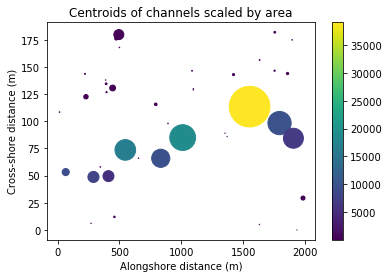

In [122]:
# Plot channel locations
s = 0.01*np.array(a)
col = -np.array(v)
plt.scatter(cx,cy,s,col)
plt.xlabel('Alongshore distance (m)')
plt.ylabel('Cross-shore distance (m)')
plt.title('Volumes of channels scaled by area')
plt.colorbar()

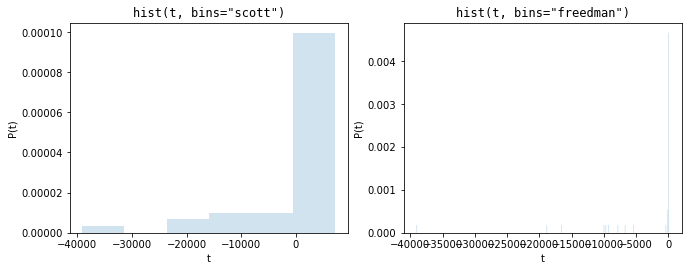

In [144]:
# Draw histograms with two different bin widths - not helpful for these data
# https://docs.astropy.org/en/stable/visualization/histogram.html
    
from astropy.visualization import hist

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
#for i, bins in enumerate(['knuth', 'blocks']):
#for i, bins in enumerate([5, 10]):
for i, bins in enumerate(['scott', 'freedman']):

    hist( np.array(v), bins=bins, ax=ax[i], histtype='stepfilled',
            alpha=0.2, density=True)
    ax[i].set_xlabel('t')
    ax[i].set_ylabel('P(t)')
    ax[i].set_title('hist(t, bins="{0}")'.format(bins),
                    fontdict=dict(family='monospace'))

#### At this point, we could us various critera to determine real channels.
* Size - some threshold size
* Location: cy should not be too far back on island